# Dummy avg model!

This model just takes the average of the train density as a guess for the test-set

In [9]:
import sys, os, json
from scf_guess_tools import Backend
import numpy as np
sys.path.append('../src/')
from scf_guess_datasets import Qm9Isomeres
import matplotlib.pyplot as plt
from uncertainties import ufloat
import scf_guess_datasets, pickle
from utils import find_repo_root
project_root_dir = find_repo_root()
print("Project root directory:", project_root_dir)

BASIS_PATH = os.path.join(project_root_dir, "scripts/6-31g_2df_p_custom_nwchem.gbs")

Project root directory: /home/ewachmann/REPOS/Masterarbeit


In [5]:
dataset = Qm9Isomeres(
    "/home/dmilacher/datasets/data", 
    size = 500, # number of molecules to load
    val=0.1, # using 80% training / 10 % val / 10% test split
    test=0.1,
)

In [6]:
from mgnn.MolGraphNetwork import MolGraphNetwork

MGNN = MolGraphNetwork(dataset=dataset,
                       basis=BASIS_PATH,
                       backend=Backend.PY,
                       batch_size=16,
                       hidden_dim=256,
                       message_passing_steps=4,
                       edge_threshold_val=3,
                       message_net_layers=3,
                       message_net_dropout=0.15,
                       target="density",
                       data_aug_factor=1,
                       verbose_level=2)
MGNN.load_data()
MGNN.load_model(f"{project_root_dir}/3_studies/Block_guessing/models/MGNN_6-31G_NO_AUG_07_07_manual_ref.pth")

Setting verbose level to: 2
Loading 500 files from qm9_isomeres...
Loading 400 files for train set from /home/ewachmann/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9_isomeres/xyz...
Loading 50 files for val set from /home/ewachmann/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9_isomeres/xyz...
Loading 50 files for test set from /home/ewachmann/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9_isomeres/xyz...


Creating training graphs: 400it [00:02, 151.67it/s]
Creating validation graphs: 50it [00:00, 172.15it/s]
Creating test graphs: 50it [00:00, 94.18it/s] 


Total samples: 500, Train: 400, Val: 50, Test: 50
Found 3 center keys (['C', 'H', 'O']) and 6 edge keys (['C_C', 'C_H', 'C_O', 'H_H', 'H_O', 'O_O']) in the training set. -> Totaling 9 unique encoder/decoder.
Normalization factors computed and applied.
Center stats: {'C': (0.08893045239638739, 0.2721039375810204), 'H': (0.3772194703420003, 0.4689655636092979), 'O': (0.08820201116919178, 0.2707920626400333)}, Edge stats: {'C_C': (0.0011760330437032402, 0.06722017499561404), 'C_H': (0.006002088116921686, 0.08899061742111722), 'C_O': (0.0006347355153139232, 0.05741605368722725), 'H_H': (0.014465763551363572, 0.05865220878540266), 'H_O': (0.0024979208887975805, 0.05124095921518987), 'O_O': (-0.000207575137635023, 0.02002456199551411)}
First train batch: 304 atoms, 2628 edges, 304 center blocks.
Found center block size 351 for atom type O.
Found center block size 351 for atom type C.
Found center block size 15 for atom type H.
Found edge block size 676 for edge type C_O.
Found edge block siz

In [ ]:
# iterations for GNN initial
test_graphs = MGNN.get_graphs("test")
density_preds = MGNN.predict(test_graphs, include_target=False, transform_to_density=True)
# GNN guess
gnn_iterations = []
for i, key in enumerate(dataset.test_keys):
        solver = dataset.solver(key)
        overlap, hcore, density, fock, status = scf_guess_datasets.solve(solver, density_preds[i].astype(np.float64))
        gnn_iterations.append(status.iterations)
        print(f"Sample {i}: Cycles with GNN guess: {status.iterations}")
        with open(os.path.join(MGNN.save_path, f"gnn_iterations.json"), "wb") as f:
                json.dump(gnn_iterations, f, indent=4)

In [3]:
# obtain guess iteration performance on test set
try:
    scheme_iterations = {dataset.schemes[i]: [] for i in range(len(dataset.schemes))}
    for key in dataset.test_keys: #! only use half of the validation set -> which is the test set used by the model!
        for scheme, sample in dataset.guesses(key).items():
            scheme_iterations[scheme].append(sample.status.iterations)
    for scheme, iterations in scheme_iterations.items():
        print(f"{scheme}: {np.mean(iterations):.2f} +- {np.std(iterations):.2f} iterations")
except FileNotFoundError: 
    import pickle
    with open(f"{project_root_dir}/3_studies/Block_guessing/models/guessing_iterations.pkl", "rb") as f:
        scheme_iterations = pickle.load(f)


1e: 18.80 +- 1.82 iterations
vsap: 14.18 +- 0.93 iterations
sap: 16.56 +- 1.90 iterations
minao: 10.76 +- 0.59 iterations


# Mean density guess

In [7]:
# now 0-D guess!
densities = []
for key in dataset.train_keys: 
    sample = dataset.solution(key)
    densities.append(sample.density)
densities = np.array(densities)
mean_density = np.mean(densities, axis=0)
iterations = []

FileNotFoundError: [Errno 2] No such file or directory: '/home/dmilacher/datasets/data/qm9_isomeres/keys.pkl'

In [ ]:
rerun = False
if rerun == True:
    test_keys = dataset.test_keys
    for i, key in enumerate(test_keys):
        solver = dataset.solver(test_keys[i])
        overlap, hcore, density, fock, status = scf_guess_datasets.solve(solver, mean_density.astype(np.float64))
        iterations.append(status.iterations)
        print(f"Sample {i}: Cycles with 0D guess: {status.iterations}")
    mean_own = np.mean(iterations)
    std_own = np.std(iterations)
    iter_own = ufloat(mean_own, std_own)
    print(f"Average iterations with own guess: {iter_own:.2f}")
    import pickle
    with open(f"{project_root_dir}/3_studies/Block_guessing/models/0D_cycles.pkl", "wb") as f:
        pickle.dump(iterations, f)

In [7]:
with open(f"{project_root_dir}/3_studies/Block_guessing/models/0D_cycles.pkl", "rb") as f:
    iterations = pickle.load(f)
mean_own = np.mean(iterations)
std_own = np.std(iterations)
iter_own = ufloat(mean_own, std_own)
scheme_iterations["0-D"] = iterations
print(f"Average iterations with own guess: {iter_own:.2f}")

Average iterations with own guess: 17.10+/-1.45


In [9]:
# reorder dict according to mean
scheme_iterations = {k: v for k, v in sorted(scheme_iterations.items(), key=lambda item: np.mean(item[1]))}
with open(f"{project_root_dir}/latex/scripts/gnn/plot_data/scheme_iterations_0D_model.pkl", "wb") as f:
    pickle.dump(scheme_iterations, f)

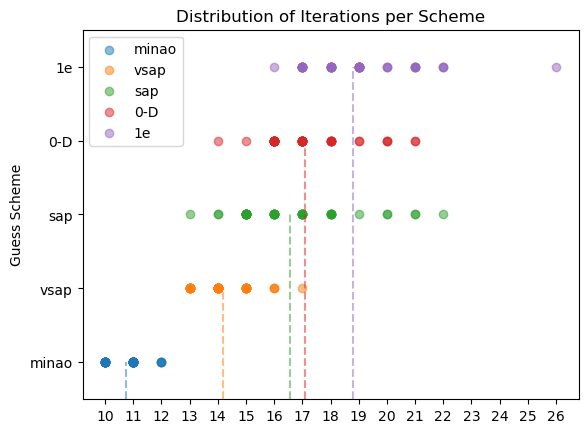

In [10]:
for i, (scheme, iterations) in enumerate(scheme_iterations.items()):
    color = plt.scatter(iterations, [scheme]*len(iterations), label=scheme, alpha=0.5).get_facecolor()[0]
    plt.vlines(np.mean(iterations), ymin=-0.5, ymax=i, colors=[color], linestyles='dashed')
plt.ylim(-0.5, len(scheme_iterations) - 0.5)
plt.xticks(np.arange(10,max([max(iterations) for iterations in scheme_iterations.values()]) + 1, 1))
plt.ylabel('Guess Scheme')
plt.title('Distribution of Iterations per Scheme')
plt.legend()